In [2]:
from langgraph.graph import StateGraph,START,END
from typing import TypedDict,Literal,Annotated
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage,HumanMessage

In [3]:
generator_llm=ChatOpenAI(model='gpt-4o')
evaluator_llm=ChatOpenAI(model='gpt-4o-mini')
optimizer_llm=ChatOpenAI(model='gpt-4o')


In [9]:
from pydantic import BaseModel, Field

class TweetEvaluation(BaseModel):
    evaluation: Literal["approved", "needs_improvement"] = Field(..., description="Final evaluation result.")
    feedback: str = Field(..., description=" feedback for the tweet.")
    


In [10]:
structured_evaluator_llm=evaluator_llm.with_structured_output(TweetEvaluation)

In [6]:
class TweetState(TypedDict):
    topic:str
    tweet:str
    evaluation:Literal["approved","need_improvement"]
    feedback:str
    iteration:int
    max_iteration:int

In [7]:
def generate_tweet(state: TweetState):
    
    messages=[
        SystemMessage(content="you are funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
            write a short,original, and hilarious tweet on the topic "{state['topic']}"         
            
            Rules:
            -Do not use question answer format
            -max 280 characters
            -use observation humor,irony,sarcasm,or cultural references
            -Think in meme logic,punchlines,or relatable takes
            -use simple,day to day english
            
            """)
    ]
    
    response=generator_llm.invoke(messages).content
    
    return {'tweet':response}
    


In [11]:
def evaluate_tweet(state: TweetState):
    
    messages = [
    SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f"""
Evaluate the following tweet:

Tweet: "{state['tweet']}"

Use the criteria below to evaluate the tweet:

1. Originality – Is this fresh, or have you seen it a hundred times before?
2. Humor – Did it genuinely make you smile, laugh, or chuckle?
3. Punchiness – Is it short, sharp, and scroll-stopping?
4. Virality Potential – Would people retweet or share it?
5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

### Respond ONLY in structured format:
- evaluation: "approved" or "needs_improvement"
- feedback: One paragraph explaining the strengths and weaknesses
""")
]

    
    response=structured_evaluator_llm.invoke(messages)

    return {'evaluation':response.evaluation,'feedback':response.feedback}

In [12]:
def optimize_tweet(state:TweetState):
    messages = [
    SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
    HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{state['feedback']}"

Topic: "{state['topic']}"
Original Tweet:
{state['tweet']}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
]
    
    response=optimizer_llm.invoke(messages).content
    iteration=state['iteration']+1
    
    
    return {'tweet':response,'iteration':iteration}


In [13]:
def route_evaluation(state:TweetState):
    if state['evaluation']=='approved' or state['iteration']>=state['max_iteration']:
        return "approved"
    else:
        return "need_improvement" 

In [14]:
graph=StateGraph(TweetState)

graph.add_node('generate',generate_tweet)
graph.add_node('evaluate',evaluate_tweet)
graph.add_node('optimize',optimize_tweet)

graph.add_edge(START,'generate')
graph.add_edge('generate','evaluate')
graph.add_conditional_edges('evaluate',route_evaluation,{'approved':END,'need_improvement':'optimize'})
graph.add_edge('optimize','evaluate')

workflow=graph.compile()



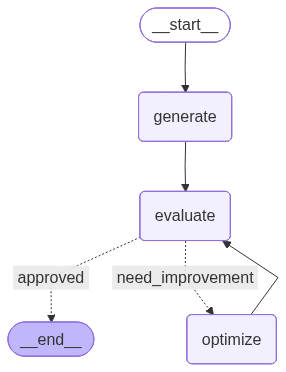

In [15]:
workflow

In [16]:
initial_state={
    'topic':'Indian Railways',
    'iteration':1,
    'max_iteration':5
}

workflow.invoke(initial_state)

{'topic': 'Indian Railways',
 'tweet': '"Indian Railways: Where every train ride feels like a quest for Platform 9¾. Just remember, pack snacks! It\'s long enough to ponder life\'s mysteries, but short enough to risk waking up on Uncle Sleeping Beauty\'s shoulder. 🚂🥪😴"',
 'evaluation': 'approved',
 'feedback': 'This tweet is refreshing and original, drawing a clever comparison between Indian Railways and a magical quest to Platform 9¾. The humor resonates well, particularly with relatable observations about long train rides and unexpected sleeping companions, resulting in an enjoyable read. Its punchiness is slightly diluted by the length but still maintains a good flow, while the emoji adds a light touch without overwhelming the text. The tweet has clear virality potential as it taps into shared experiences, appealing to a broad audience. Overall, it fits well within the format guidelines, making it an engaging and shareable tweet.',
 'iteration': 2,
 'max_iteration': 5}